In [1]:
import pandas as pd 
import numpy as np 

import enchant
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

import re 
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk.corpus
from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


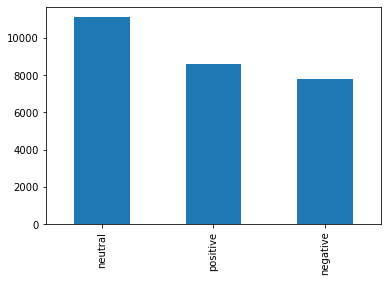

In [4]:
df_train.sentiment.value_counts().plot(kind = 'bar');

# Data preprocessing

In [5]:
def text_cleaning(df):

    df.drop('textID', axis= 1 , inplace = True)
    df.dropna(axis=0, inplace= True)
    df['sentiment'] = df['sentiment'].apply(lambda x: 0 if x == 'negative' else(1 if x == 'neutral' else 2))
    df['text_clean'] = df['text'].str.lower()
    df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", str(x)))  
    df['text_clean'] = df['text_clean'].apply(lambda x: re.sub(r"\d+", "", x))
    df['text_tokonize'] = df['text_clean'].apply(lambda x: word_tokenize(x))
    return df
df_train = text_cleaning(df_train)
df_test = text_cleaning(df_test)


In [6]:
def remove_stopwords(text):
    text=[word for word in text if word not in stop]
    return text

df_train['text_withNoStopWords'] = df_train['text_tokonize'].apply(lambda x: remove_stopwords(x))
df_test['text_withNoStopWords'] = df_test['text_tokonize'].apply(lambda x: remove_stopwords(x))

In [7]:
def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN) 

def lemmitizer(x):
    x = [WordNetLemmatizer().lemmatize(word, get_pos(word)) for word in x ]
    return x

df_train['clean_text'] = df_train['text_withNoStopWords'].apply(lambda x:lemmitizer(x))
df_test['clean_text'] = df_test['text_withNoStopWords'].apply(lambda x:lemmitizer(x))

In [8]:
df_train.head()

,text,selected_text,sentiment,text_clean,text_tokonize,text_withNoStopWords,clean_text
0,"I`d have responded, if I were going","I`d have responded, if I were going",1,id have responded if i were going,"[id, have, responded, if, i, were, going]","[id, responded, going]","[id, respond, go]"
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,sooo sad i will miss you here in san diego,"[sooo, sad, i, will, miss, you, here, in, san,...","[sooo, sad, miss, san, diego]","[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,bullying me,0,my boss is bullying me,"[my, boss, is, bullying, me]","[boss, bullying]","[bos, bullying]"
3,what interview! leave me alone,leave me alone,0,what interview leave me alone,"[what, interview, leave, me, alone]","[interview, leave, alone]","[interview, leave, alone]"
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,sons of why couldnt they put them on the rel...,"[sons, of, why, couldnt, they, put, them, on, ...","[sons, couldnt, put, releases, already, bought]","[son, couldnt, put, release, already, bought]"


In [9]:
d = enchant.Dict("en_US")
def checkIfEnglish(text):
    text=[word for word in text if d.check(word)==True]    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(text))

In [10]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x:  checkIfEnglish(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: checkIfEnglish(x))



In [11]:
df_train.head()

,text,selected_text,sentiment,text_clean,text_tokonize,text_withNoStopWords,clean_text
0,"I`d have responded, if I were going","I`d have responded, if I were going",1,id have responded if i were going,"[id, have, responded, if, i, were, going]","[id, responded, going]",id respond go
1,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,sooo sad i will miss you here in san diego,"[sooo, sad, i, will, miss, you, here, in, san,...","[sooo, sad, miss, san, diego]",sad miss
2,my boss is bullying me...,bullying me,0,my boss is bullying me,"[my, boss, is, bullying, me]","[boss, bullying]",bullying
3,what interview! leave me alone,leave me alone,0,what interview leave me alone,"[what, interview, leave, me, alone]","[interview, leave, alone]",interview leave alone
4,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,sons of why couldnt they put them on the rel...,"[sons, of, why, couldnt, they, put, them, on, ...","[sons, couldnt, put, releases, already, bought]",son put release already bought


In [12]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: x if len(x) >=2 else None )
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: x if len(x) >= 2 else None )

In [13]:
df_train.dropna(axis=0, inplace=True)
df_test.dropna(axis=0, inplace=True)

In [14]:
def split_X_Y(df):
    X = df['clean_text']
    Y = df['sentiment']
    return X, Y

X_train, Y_train = split_X_Y(df_train)
X_test, Y_test = split_X_Y(df_test)

In [15]:
count_vect = CountVectorizer(ngram_range=(1,1))
count_vect_train = count_vect.fit_transform(X_train)
count_vect_train = count_vect_train.toarray()
count_vect_test = count_vect.transform(X_test)
count_vect_test = count_vect_test.toarray()

In [16]:
vocab = count_vect.get_feature_names()

# Model Training 

In [17]:
model = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg', n_jobs = -1,
                                     class_weight = 'balanced', C = 0.1, random_state = 42)
model.fit(count_vect_train,Y_train)

LogisticRegression(C=0.1, class_weight='balanced', multi_class='multinomial',
                   n_jobs=-1, random_state=42, solver='newton-cg')

# Model evaluation

In [18]:
y_pred = model.predict(count_vect_test)

score = f1_score(Y_test, y_pred, average = 'weighted')

print("f1 score: {}".format(score))
print(classification_report(Y_test, y_pred))

f1 score: 0.7002944543924225
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       996
           1       0.65      0.69      0.67      1384
           2       0.79      0.72      0.75      1097

    accuracy                           0.70      3477
   macro avg       0.71      0.70      0.70      3477
weighted avg       0.70      0.70      0.70      3477

